In [1]:
from transformers import BridgeTowerModel, BridgeTowerProcessor
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision import transforms
from PIL import Image
from torch.nn.functional import pad
import math

c:\Users\Bridget Leonard\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Part 1: Bridgetower Introduction

### 1 Model Investigation

In [2]:
# Load model directly
from transformers import AutoModel
model = AutoModel.from_pretrained("BridgeTower/bridgetower-base")

#### 1.1 Model Architecture

In [3]:
model

BridgeTowerModel(
  (cross_modal_text_transform): Linear(in_features=768, out_features=768, bias=True)
  (cross_modal_image_transform): Linear(in_features=768, out_features=768, bias=True)
  (token_type_embeddings): Embedding(2, 768)
  (vision_model): BridgeTowerVisionModel(
    (visual): BridgeTowerVisionTransformer(
      (embeddings): BridgeTowerVisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
        (position_embedding): Embedding(325, 768)
      )
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): BridgeTowerTransformer(
        (resblocks): ModuleList(
          (0-11): 12 x BridgeTowerResidualAttention(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): ModuleDict(
              (c

#### 1.2 Model Function

In [4]:
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
text = "hello world"

processor = BridgeTowerProcessor.from_pretrained("BridgeTower/bridgetower-base")
model = BridgeTowerModel.from_pretrained("BridgeTower/bridgetower-base")
# Prepare inputs
encoding = processor(image, text, return_tensors="pt")
# Forward pass
outputs = model(**encoding)
outputs.keys()
#odict_keys(['text_feats', 'image_feats', 'pooler_output'])


`AnnotionFormat` is deprecated and will be removed in v4.38. Please use `transformers.image_utils.AnnotationFormat` instead.


odict_keys(['text_features', 'image_features', 'pooler_output'])

In [5]:
outputs.image_features

tensor([[[ 0.4191,  0.1899, -0.6848,  ..., -1.0601, -1.2401, -1.7667],
         [-0.6503, -0.2314, -0.8267,  ..., -0.0675, -0.3931, -1.6485],
         [ 0.4087, -0.2456, -0.1298,  ...,  0.1705, -0.5598, -1.6388],
         ...,
         [ 0.2994,  0.2039, -0.8922,  ...,  0.4237, -0.0646, -1.6678],
         [-1.2473, -0.4323, -1.1980,  ..., -0.9151, -0.4366, -2.5395],
         [ 0.5453,  0.4352, -1.0627,  ...,  0.0493,  0.5887, -2.0345]]],
       grad_fn=<NativeLayerNormBackward0>)

### 2 Extracting Layer Activations

#### 2.1 Define Model

In [6]:
model = model = AutoModel.from_pretrained("BridgeTower/bridgetower-base")

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [8]:
# Get relevant layers: Start with only convolutional layer
model_weights = []

conv_layers = []

model_children = list(model.children())

vision_model = list(model_children[3].children())
vision_model = list(vision_model[0].children())
patch_embedding = list(vision_model[0].children())
patch_embedding = patch_embedding[0]

#### 2.2 Define Inputs

In [9]:
# Only run if image can't be found
os.chdir("..")

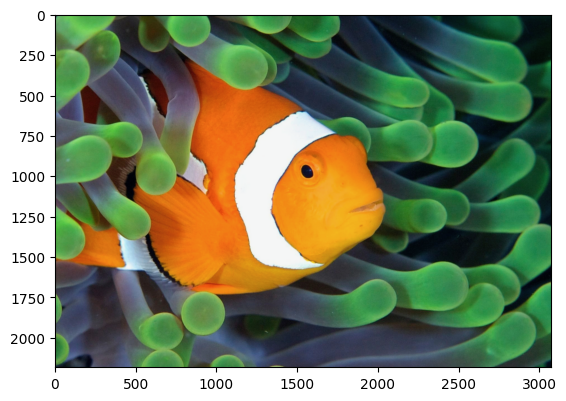

In [10]:
image = Image.open(str('tensorflow_tutorial\images\clown-fish.png'))
plt.imshow(image)

In [11]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])

In [12]:
image = transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

Image shape before: torch.Size([3, 256, 256])
Image shape after: torch.Size([1, 3, 256, 256])


#### 2.3 Get Layer Extraction

In [13]:
image = patch_embedding(image)
output = image
name = (str(patch_embedding))
print(output.shape)

torch.Size([1, 768, 16, 16])


In [14]:
feature_map = output.squeeze(0)
gray_scale = torch.sum(feature_map,0)
gray_scale = gray_scale / feature_map.shape[0]
fm = gray_scale.data.cpu().numpy()
print(fm.shape)

(16, 16)


Text(0.5, 1.0, 'Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)')

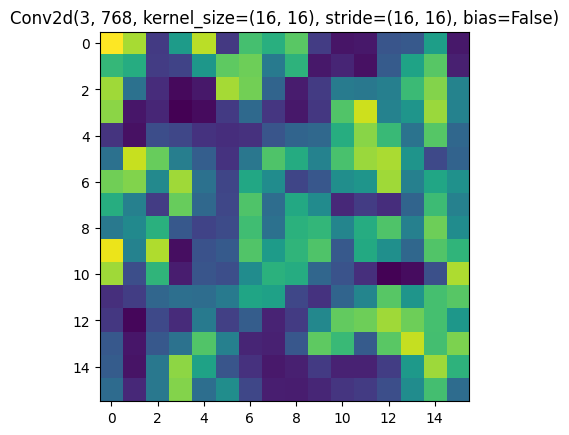

In [15]:
plt.imshow(fm)
plt.title(name)

### 3 Forward Passes
Just passing the inputs through the layer does not provide us a comprehensive feature map since it disregards layers before it. Instead, we can use forward hooks that mark important layers in our model and extract their output to a dictionary while the full model is running.

In [16]:
# only run if image can't be found
# os.chdir("..")

#### 3.1 Set Up Model and Hooks

In [17]:
# input (text and image)
processor = BridgeTowerProcessor.from_pretrained("BridgeTower/bridgetower-base")
image = Image.open(str('tensorflow_tutorial\images\elephant.png')).convert('RGB')
text = "An elephant in grass"
inputs = processor(image, text, return_tensors='pt')

# model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BridgeTowerModel.from_pretrained("BridgeTower/bridgetower-base")
model = model.to(device)

# placeholder for batch features
features = {}
def get_features(name):
    def hook(model, input, output):
        # detached_outputs = [tensor.detach() for tensor in output]
        last_output = output[-1].detach()
        features[name] = last_output  # detached_outputs
    return hook

hook_names = []
hooks_to_remove = {}
# register forward hooks with layers of choice
# First, convolutional layers
patch_embed = model.vision_model.visual.embeddings.patch_embedding.register_forward_hook(get_features('patchEmbed'))
hook_names.append('patch_embed')

final_vis = model.vision_model.visual.ln_post.register_forward_hook(get_features('final_vis'))
hook_names.append('final_vis')

final_text = model.text_model.pooler.activation.register_forward_hook(get_features('final_text'))
hook_names.append('final_text')

cm_image_pooler = model.cross_modal_image_pooler.register_forward_hook(get_features('cm_image_pooler'))
hook_names.append('cm_image_pooler')

cm_text_pooler = model.cross_modal_text_pooler.register_forward_hook(get_features('cm_text_pooler'))
hook_names.append('cm_text_pooler')

# Next: residual attention layers
for i, resblock in enumerate(model.vision_model.visual.transformer.resblocks):
    hook_name = f"resblock_{i}"

    hook_ref = resblock.register_forward_hook(get_features(hook_name))

    hooks_to_remove[hook_name] = hook_ref

# Next: Text encoder layers
for i, encoder in enumerate(model.text_model.encoder.layer):
    hook_name = f"text_encoder_{i}"
    hook_names.append(hook_name)

    hook_ref = encoder.register_forward_hook(get_features(hook_name))

    hooks_to_remove[hook_name] = hook_ref

# Next: Cross modal image layers
for i, cm_image in enumerate(model.cross_modal_image_layers):
    hook_name = f"cm_image_{i}" 
    hook_names.append(hook_name)

    hook_ref = cm_image.register_forward_hook(get_features(hook_name))

    hooks_to_remove[hook_name] = hook_ref

# Lastly: Cross modal text layers
for i, cm_text in enumerate(model.cross_modal_text_layers):
    hook_name = f"cm_text_{i}"
    hook_names.append(hook_name)

    hook_ref = cm_text.register_forward_hook(get_features(hook_name))

    hooks_to_remove[hook_name] = hook_ref

print(hook_names)
print(hooks_to_remove)

['patch_embed', 'final_vis', 'final_text', 'cm_image_pooler', 'cm_text_pooler', 'text_encoder_0', 'text_encoder_1', 'text_encoder_2', 'text_encoder_3', 'text_encoder_4', 'text_encoder_5', 'text_encoder_6', 'text_encoder_7', 'text_encoder_8', 'text_encoder_9', 'text_encoder_10', 'text_encoder_11', 'cm_image_0', 'cm_image_1', 'cm_image_2', 'cm_image_3', 'cm_image_4', 'cm_image_5', 'cm_text_0', 'cm_text_1', 'cm_text_2', 'cm_text_3', 'cm_text_4', 'cm_text_5']
{'resblock_0': <torch.utils.hooks.RemovableHandle object at 0x0000015994F63590>, 'resblock_1': <torch.utils.hooks.RemovableHandle object at 0x0000015994F63490>, 'resblock_2': <torch.utils.hooks.RemovableHandle object at 0x0000015994F63290>, 'resblock_3': <torch.utils.hooks.RemovableHandle object at 0x0000015994F63090>, 'resblock_4': <torch.utils.hooks.RemovableHandle object at 0x0000015994F62E90>, 'resblock_5': <torch.utils.hooks.RemovableHandle object at 0x0000015994F62C90>, 'resblock_6': <torch.utils.hooks.RemovableHandle object at 

#### 3.2 Get Feature Maps

In [18]:
# forward pass [with feature extraction]
preds = model(**inputs)

print(len(features))
print(len(features.values()))

# detach the hooks
patch_embed.remove()
final_vis.remove()
final_text.remove()
cm_image_pooler.remove()
cm_text_pooler.remove()

for hook_name, hook_ref in hooks_to_remove.items():
    hook_ref.remove()

40
40


In [19]:
for fm in features.values():
    print(fm.shape)

torch.Size([1, 6, 768])
torch.Size([1, 6, 768])
torch.Size([1, 6, 768])
torch.Size([1, 6, 768])
torch.Size([1, 6, 768])
torch.Size([1, 6, 768])
torch.Size([1, 6, 768])
torch.Size([768, 18, 18])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([325, 768])
torch.Size([1, 6, 768])
torch.Size([1, 325, 768])
torch.Size([1, 6, 768])
torch.Size([1, 768])
torch.Size([1, 6, 768])
torch.Size([1, 325, 768])
torch.Size([1, 6, 768])
torch.Size([1, 768])
torch.Size([1, 6, 768])
torch.Size([1, 325, 768])
torch.Size([1, 6, 768])
torch.Size([1, 768])
torch.Size([1, 6, 768])
torch.Size([1, 325, 768])
torch.Size([1, 6, 768])
torch.Size([1, 768])
torch.Size([1, 6, 768])
torch.Size([1, 325, 768])
torch.Size([1, 6, 768])
torch.Size([1, 768])
torch.Size([1, 6, 768])
torch.Size([1, 325, 768])
torch.Size([768])
torch.Size([768])


In [20]:
names = []
processed = []

for name, tensor in features.items():
        tensor = tensor.squeeze(0) # Remove batch dimension if present

        if len(tensor.shape) == 3:
            # If the tensor has shape [C, H, W], resize it to (18, 18)
            feature_map = tensor
        else:
            channel = tensor.numel() // (16 * 16)
            # If the tensor has shape [H, W] or [C], reshape it to (18, 18)
            feature_map = tensor.view(channel, 16, 16)  # Reshape to (1, 1, 768) for consistency
            # feature_map = F.interpolate(feature_map, size=(18, 18), mode='bilinear', align_corners=False)
            # feature_map = feature_map.squeeze(0).squeeze(0)
        # print(feature_map.shape)

        gray_scale = torch.sum(feature_map, 0)
        gray_scale = gray_scale / feature_map.shape[0]

        processed.append(gray_scale.data.cpu().numpy())
        names.append(name)
#         # normalize the values
#         feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())

#         processed[name] = feature_map.data.cpu().numpy()

for fm in processed:
     print(fm.shape)

(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(18, 18)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)


#### 3.3 Visualize The Feature Maps

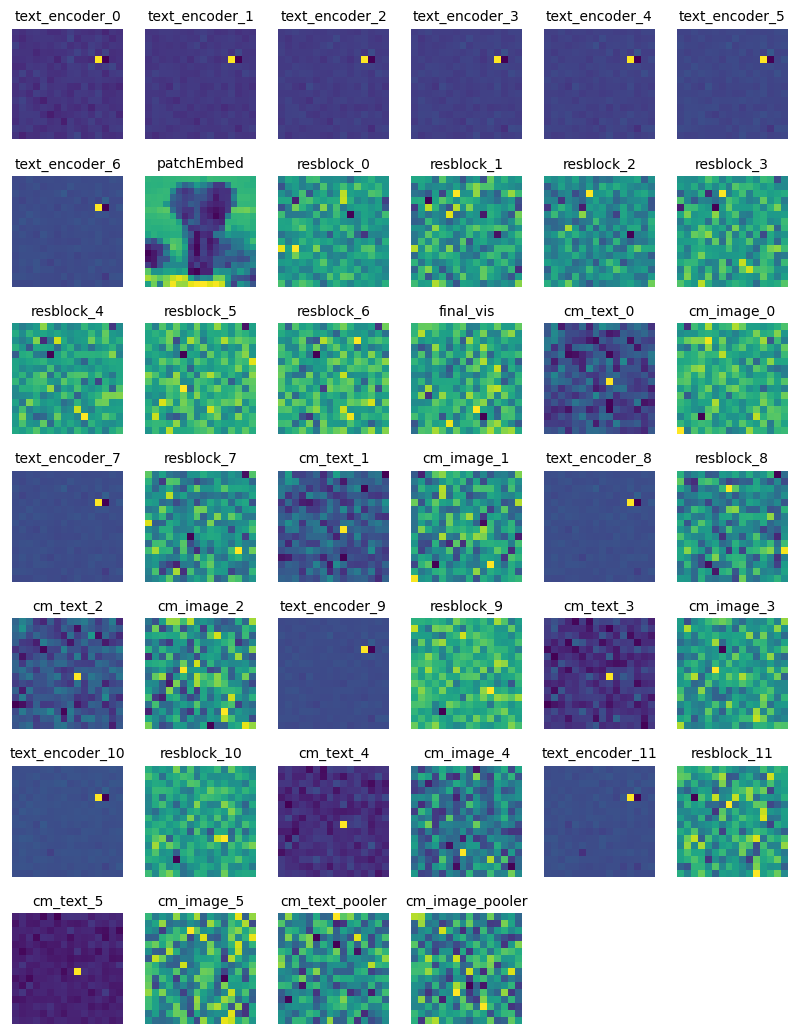

In [21]:
fig = plt.figure(figsize=(10,15))
for i in range(len(processed)):
    a = fig.add_subplot(8, 6, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i], fontsize=10)
# plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

### 4 Loop Through Two Inputs
The goal is to pass frames from a movie to this model. This requires us to loop through the model and change the inputs while still collecting layer activations for each input. Let's try a simplified version of this with just two different photos as our two inputs to loop through.

#### 4.1 Model Set-up
We can define the hooks before we run our model. We can continue to loop through the inputs without removing and re-registering our hooks because our model and layers of interest remain the same. We want to prioritize the computing speed of our model.

In [22]:
# set-up
# model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BridgeTowerModel.from_pretrained("BridgeTower/bridgetower-base")
model = model.to(device)

# placeholder for batch features
features = {}
def get_features(name):
    def hook(model, input, output):
        # detached_outputs = [tensor.detach() for tensor in output]
        last_output = output[-1].detach()
        features[name] = last_output  # detached_outputs
    return hook

hook_names = []
hooks_to_remove = {}
# register forward hooks with layers of choice
# First, convolutional layers
patch_embed = model.vision_model.visual.embeddings.patch_embedding.register_forward_hook(get_features('patchEmbed'))
hook_names.append('patch_embed')

final_vis = model.vision_model.visual.ln_post.register_forward_hook(get_features('final_vis'))
hook_names.append('final_vis')

final_text = model.text_model.pooler.activation.register_forward_hook(get_features('final_text'))
hook_names.append('final_text')

cm_image_pooler = model.cross_modal_image_pooler.register_forward_hook(get_features('cm_image_pooler'))
hook_names.append('cm_image_pooler')

cm_text_pooler = model.cross_modal_text_pooler.register_forward_hook(get_features('cm_text_pooler'))
hook_names.append('cm_text_pooler')

# Next: residual attention layers
for i, resblock in enumerate(model.vision_model.visual.transformer.resblocks):
    hook_name = f"resblock_{i}"

    hook_ref = resblock.register_forward_hook(get_features(hook_name))

    hooks_to_remove[hook_name] = hook_ref

# Next: Text encoder layers
for i, encoder in enumerate(model.text_model.encoder.layer):
    hook_name = f"text_encoder_{i}"
    hook_names.append(hook_name)

    hook_ref = encoder.register_forward_hook(get_features(hook_name))

    hooks_to_remove[hook_name] = hook_ref

# Next: Cross modal image layers
for i, cm_image in enumerate(model.cross_modal_image_layers):
    hook_name = f"cm_image_{i}" 
    hook_names.append(hook_name)

    hook_ref = cm_image.register_forward_hook(get_features(hook_name))

    hooks_to_remove[hook_name] = hook_ref

# Lastly: Cross modal text layers
for i, cm_text in enumerate(model.cross_modal_text_layers):
    hook_name = f"cm_text_{i}"
    hook_names.append(hook_name)

    hook_ref = cm_text.register_forward_hook(get_features(hook_name))

    hooks_to_remove[hook_name] = hook_ref

print(hook_names)
print(hooks_to_remove)

['patch_embed', 'final_vis', 'final_text', 'cm_image_pooler', 'cm_text_pooler', 'text_encoder_0', 'text_encoder_1', 'text_encoder_2', 'text_encoder_3', 'text_encoder_4', 'text_encoder_5', 'text_encoder_6', 'text_encoder_7', 'text_encoder_8', 'text_encoder_9', 'text_encoder_10', 'text_encoder_11', 'cm_image_0', 'cm_image_1', 'cm_image_2', 'cm_image_3', 'cm_image_4', 'cm_image_5', 'cm_text_0', 'cm_text_1', 'cm_text_2', 'cm_text_3', 'cm_text_4', 'cm_text_5']
{'resblock_0': <torch.utils.hooks.RemovableHandle object at 0x00000159942D9750>, 'resblock_1': <torch.utils.hooks.RemovableHandle object at 0x0000015987F4B050>, 'resblock_2': <torch.utils.hooks.RemovableHandle object at 0x0000015994294110>, 'resblock_3': <torch.utils.hooks.RemovableHandle object at 0x0000015994294050>, 'resblock_4': <torch.utils.hooks.RemovableHandle object at 0x00000159942959D0>, 'resblock_5': <torch.utils.hooks.RemovableHandle object at 0x0000015994294250>, 'resblock_6': <torch.utils.hooks.RemovableHandle object at 

#### 4.2 Define Inputs

In [23]:
processor = BridgeTowerProcessor.from_pretrained("BridgeTower/bridgetower-base")
images = [Image.open(str('tensorflow_tutorial\images\elephant.png')).convert('RGB'),
          Image.open(str('tensorflow_tutorial\images\ice-cream.png')).convert('RGB')]
texts = ["An elephant in grass",
         "A bowl of ice cream"]

inputs = [processor(image, text, return_tensors='pt') for image, text in zip(images, texts)]

#### 4.3 Loop Through the Inputs

In [24]:
# A dictionary for storing each run
data = {}

for i, input in enumerate(inputs):
    run_name = f"run_{i}"
    preds = model(**input)

    names = []
    processed = []

    for name, tensor in features.items():
            tensor = tensor.squeeze(0) # Remove batch dimension if present

            if len(tensor.shape) == 3:
                feature_map = tensor
            else:
                channel = tensor.numel() // (16 * 16)
                feature_map = tensor.view(channel, 16, 16)

            gray_scale = torch.sum(feature_map, 0)
            gray_scale = gray_scale / feature_map.shape[0]

            processed.append(gray_scale.data.cpu().numpy())
            names.append(name)
    
    data[run_name] = [names, processed]

# Remove hooks
patch_embed.remove()
final_vis.remove()
final_text.remove()
cm_image_pooler.remove()
cm_text_pooler.remove()

for hook_name, hook_ref in hooks_to_remove.items():
    hook_ref.remove()

#### 4.4 Visualize the Runs

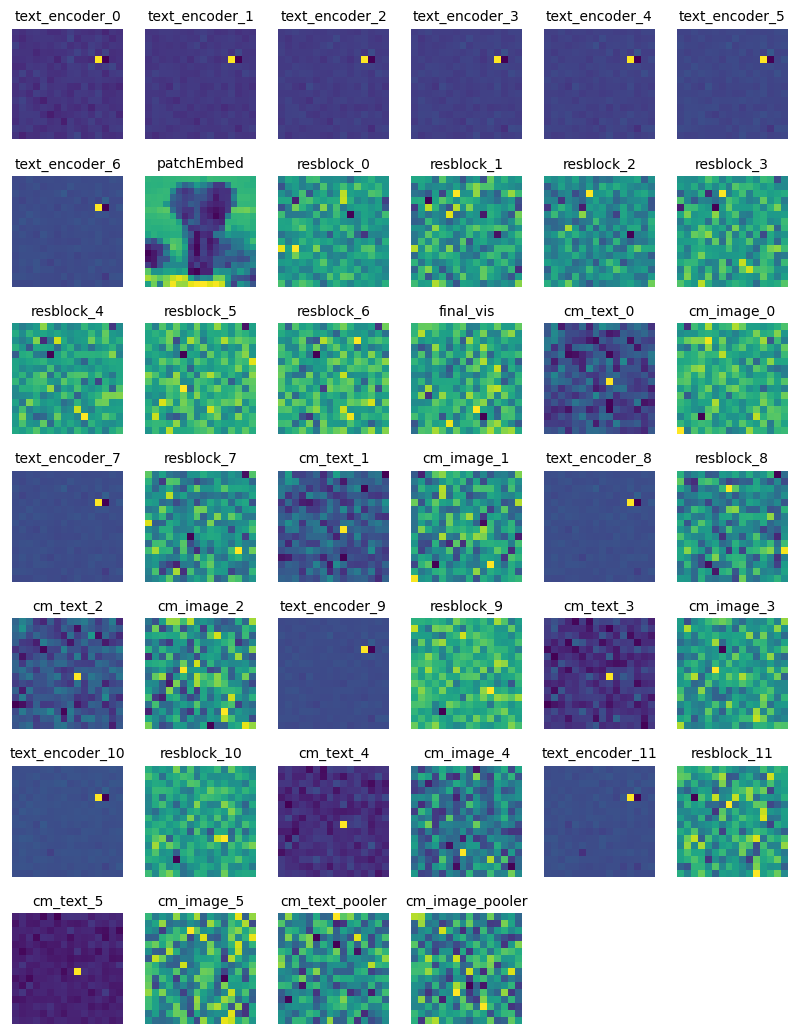

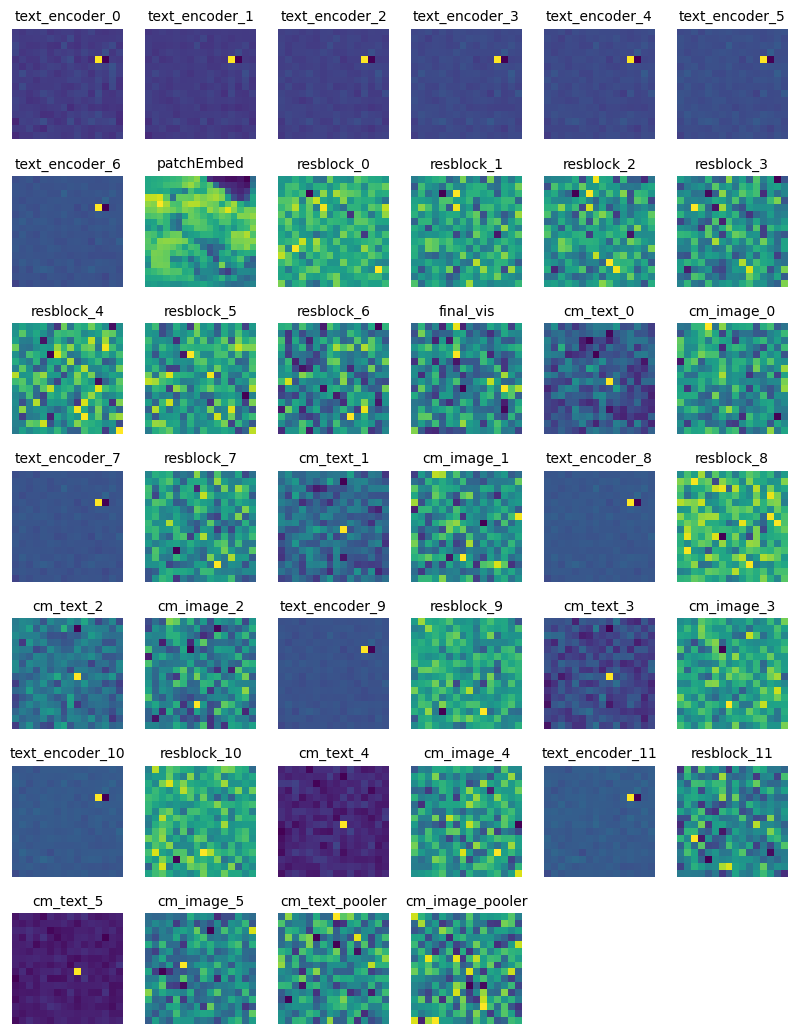

In [25]:
for run, info in data.items():
    names = info[0]
    processed = info[1]
    fig = plt.figure(figsize=(10,15))
    for i in range(len(processed)):
        a = fig.add_subplot(8, 6, i+1)
        imgplot = plt.imshow(processed[i])
        a.axis("off")
        a.set_title(names[i], fontsize=10)

#### 4.5 Adjust Data Storage
We want data from each layer to be stored together for each input. Let's set it up so that each new run appends an additional tensor each layer.

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BridgeTowerModel.from_pretrained("BridgeTower/bridgetower-base")
model = model.to(device)

# placeholder for batch features
features = {}
def get_features(name):
    def hook(model, input, output):
        # detached_outputs = [tensor.detach() for tensor in output]
        last_output = output[-1].detach()
        features[name] = last_output  # detached_outputs
    return hook

hook_names = []
hooks_to_remove = {}
# register forward hooks with layers of choice
# First, convolutional layers
patch_embed = model.vision_model.visual.embeddings.patch_embedding.register_forward_hook(get_features('patchEmbed'))
hook_names.append('patch_embed')

final_vis = model.vision_model.visual.ln_post.register_forward_hook(get_features('final_vis'))
hook_names.append('final_vis')

final_text = model.text_model.pooler.activation.register_forward_hook(get_features('final_text'))
hook_names.append('final_text')

cm_image_pooler = model.cross_modal_image_pooler.register_forward_hook(get_features('cm_image_pooler'))
hook_names.append('cm_image_pooler')

cm_text_pooler = model.cross_modal_text_pooler.register_forward_hook(get_features('cm_text_pooler'))
hook_names.append('cm_text_pooler')

# Next: residual attention layers
for i, resblock in enumerate(model.vision_model.visual.transformer.resblocks):
    hook_name = f"resblock_{i}"

    hook_ref = resblock.register_forward_hook(get_features(hook_name))

    hooks_to_remove[hook_name] = hook_ref

# Next: Text encoder layers
for i, encoder in enumerate(model.text_model.encoder.layer):
    hook_name = f"text_encoder_{i}"
    hook_names.append(hook_name)

    hook_ref = encoder.register_forward_hook(get_features(hook_name))

    hooks_to_remove[hook_name] = hook_ref

# Next: Cross modal image layers
for i, cm_image in enumerate(model.cross_modal_image_layers):
    hook_name = f"cm_image_{i}" 
    hook_names.append(hook_name)

    hook_ref = cm_image.register_forward_hook(get_features(hook_name))

    hooks_to_remove[hook_name] = hook_ref

# Lastly: Cross modal text layers
for i, cm_text in enumerate(model.cross_modal_text_layers):
    hook_name = f"cm_text_{i}"
    hook_names.append(hook_name)

    hook_ref = cm_text.register_forward_hook(get_features(hook_name))

    hooks_to_remove[hook_name] = hook_ref

processor = BridgeTowerProcessor.from_pretrained("BridgeTower/bridgetower-base")
images = [Image.open(str('tensorflow_tutorial\images\elephant.png')).convert('RGB'),
          Image.open(str('tensorflow_tutorial\images\ice-cream.png')).convert('RGB')]
texts = ["An elephant in grass",
         "A bowl of ice cream"]

inputs = [processor(image, text, return_tensors='pt') for image, text in zip(images, texts)]

In [27]:
# A dictionary for storing each run
maps = {}

for i, input in enumerate(inputs):
    preds = model(**input)

    for name, tensor in features.items():
            tensor = tensor.squeeze(0) # Remove batch dimension if present

            if len(tensor.shape) == 3:
                feature_map = tensor
            else:
                channel = tensor.numel() // (16 * 16)
                feature_map = tensor.view(channel, 16, 16)

            gray_scale = torch.sum(feature_map, 0)
            gray_scale = gray_scale / feature_map.shape[0]

            final_tensor = gray_scale.data.cpu().numpy()

            if name not in maps:
                 maps[name] = []
            
            maps[name].append(gray_scale.data.cpu().numpy())

# Remove hooks
patch_embed.remove()
final_vis.remove()
final_text.remove()
cm_image_pooler.remove()
cm_text_pooler.remove()

for hook_name, hook_ref in hooks_to_remove.items():
    hook_ref.remove()

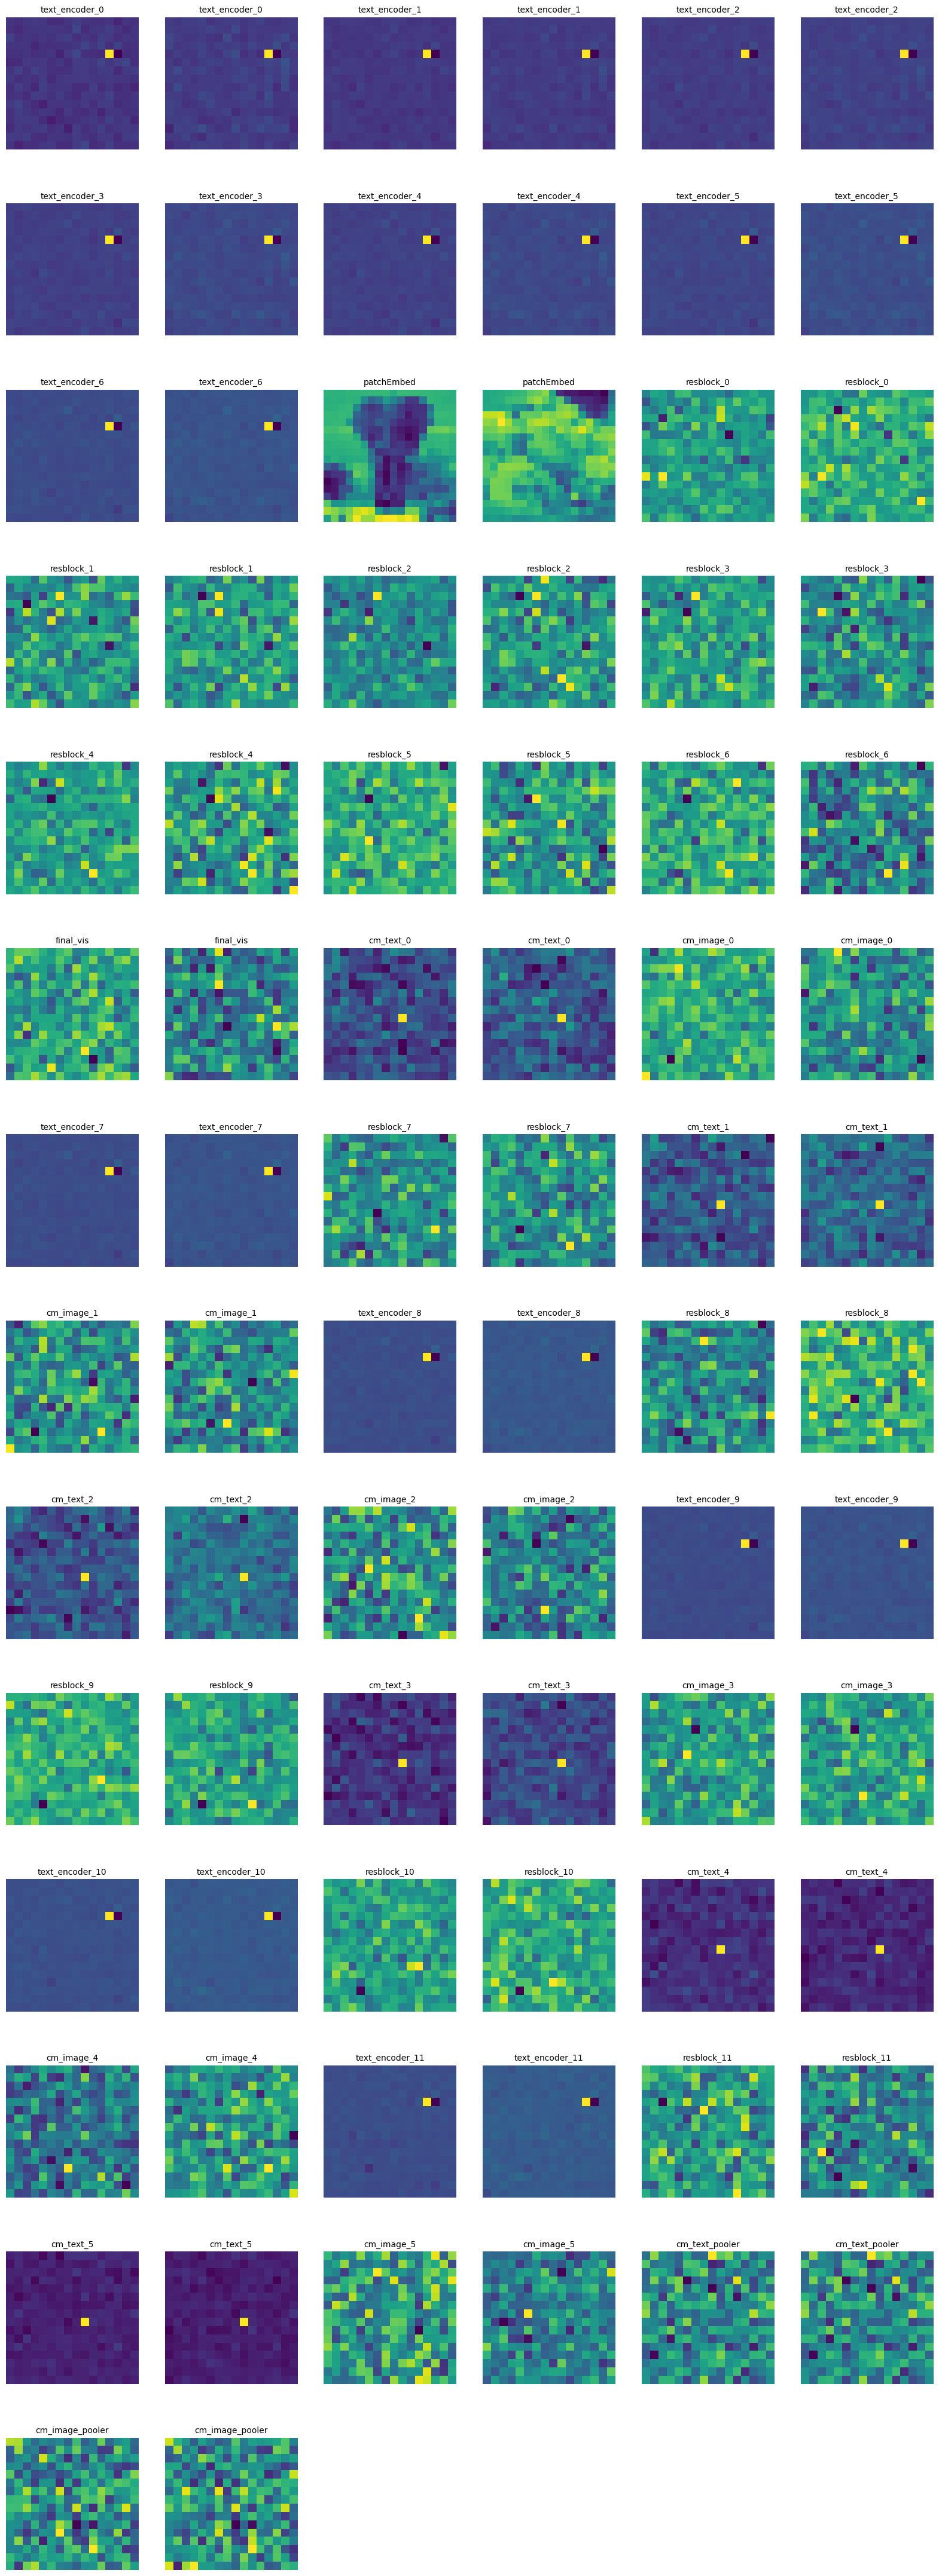

In [28]:
i = 0 # for plot position
fig = plt.figure(figsize=(20,60))
for name, tensors in maps.items():
    for tensor in tensors:
        i += 1
        a = fig.add_subplot(15, 6, i)
        imgplot = plt.imshow(tensor)
        a.axis("off")
        a.set_title(name, fontsize=10)

### 5 Create Functions

In [29]:
def setup():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BridgeTowerModel.from_pretrained("BridgeTower/bridgetower-base")
    model = model.to(device)

    # placeholder for batch features
    features = {}
    def get_features(name):
        def hook(model, input, output):
            # detached_outputs = [tensor.detach() for tensor in output]
            last_output = output[-1].detach()
            features[name] = last_output  # detached_outputs
        return hook

    hook_names = []
    hooks_to_remove = {}
    # register forward hooks with layers of choice
    # First, convolutional layers
    patch_embed = model.vision_model.visual.embeddings.patch_embedding.register_forward_hook(get_features('patchEmbed'))
    hook_names.append('patch_embed')

    final_vis = model.vision_model.visual.ln_post.register_forward_hook(get_features('final_vis'))
    hook_names.append('final_vis')

    final_text = model.text_model.pooler.activation.register_forward_hook(get_features('final_text'))
    hook_names.append('final_text')

    cm_image_pooler = model.cross_modal_image_pooler.register_forward_hook(get_features('cm_image_pooler'))
    hook_names.append('cm_image_pooler')

    cm_text_pooler = model.cross_modal_text_pooler.register_forward_hook(get_features('cm_text_pooler'))
    hook_names.append('cm_text_pooler')

    # Next: residual attention layers
    for i, resblock in enumerate(model.vision_model.visual.transformer.resblocks):
        hook_name = f"resblock_{i}"

        hook_ref = resblock.register_forward_hook(get_features(hook_name))

        hooks_to_remove[hook_name] = hook_ref

    # Next: Text encoder layers
    for i, encoder in enumerate(model.text_model.encoder.layer):
        hook_name = f"text_encoder_{i}"
        hook_names.append(hook_name)

        hook_ref = encoder.register_forward_hook(get_features(hook_name))

        hooks_to_remove[hook_name] = hook_ref

    # Next: Cross modal image layers
    for i, cm_image in enumerate(model.cross_modal_image_layers):
        hook_name = f"cm_image_{i}" 
        hook_names.append(hook_name)

        hook_ref = cm_image.register_forward_hook(get_features(hook_name))

        hooks_to_remove[hook_name] = hook_ref

    # Lastly: Cross modal text layers
    for i, cm_text in enumerate(model.cross_modal_text_layers):
        hook_name = f"cm_text_{i}"
        hook_names.append(hook_name)

        hook_ref = cm_text.register_forward_hook(get_features(hook_name))

        hooks_to_remove[hook_name] = hook_ref

    return model, hooks_to_remove

In [40]:
def inputs(folder_path, file_path):
        processor = BridgeTowerProcessor.from_pretrained("BridgeTower/bridgetower-base")

        # Get images
        images = []
        if os.path.exists(folder_path):
                items = os.listdir(folder_path)

                for item in items:
                        item_path = os.path.join(folder_path, item)
                        images.append(Image.open(str(item_path)).convert('RGB'))

        # Get text
        texts = []
        with open(file_path, 'r') as txtfile:

                for line in txtfile:
                        texts.append(line.strip())

        inputs = [processor(image, text, return_tensors='pt') for image, text in zip(images, texts)]

        num_inputs = len(inputs)
        
        return inputs, num_inputs

In [31]:
def run_model(inputs, hooks_to_remove):
    # A dictionary for storing each run
    maps = {}

    for i, input in enumerate(inputs):
        preds = model(**input)

        for name, tensor in features.items():
                tensor = tensor.squeeze(0) # Remove batch dimension if present

                if len(tensor.shape) == 3:
                    feature_map = tensor
                else:
                    channel = tensor.numel() // (16 * 16)
                    feature_map = tensor.view(channel, 16, 16)

                gray_scale = torch.sum(feature_map, 0)
                gray_scale = gray_scale / feature_map.shape[0]

                if name not in maps:
                    maps[name] = []
                
                maps[name].append(gray_scale.data.cpu().numpy())

    # Remove hooks
    patch_embed.remove()
    final_vis.remove()
    final_text.remove()
    cm_image_pooler.remove()
    cm_text_pooler.remove()

    for hook_name, hook_ref in hooks_to_remove.items():
        hook_ref.remove()

    return maps

In [32]:
def plot_maps(maps, num_inputs):
    i = 0 # for plot position
    fig = plt.figure(figsize=(20,60))
    for name, tensors in maps.items():
        for tensor in tensors:
            i += 1
            a = fig.add_subplot(60, num_inputs, i)
            imgplot = plt.imshow(tensor)
            a.axis("off")
            a.set_title(name, fontsize=10)

### 6 Averaging feature vectors over n frames (inputs)

In [36]:
def get_feature_vecs(inputs, n):
    # create overall data structure for average feature vectors
    # a dictionary with layer names as keys and a list of vectors as it values
    data = {}

    # a dictionary to store vectors for n consecutive trials
    avg_data = {}

    # loop through all inputs
    for i, input in enumerate(inputs):
        
        preds = model(**input)

        for name, tensor in features.items():
            if name not in avg_data:
                avg_data[name] = []
            avg_data[name].append(tensor)
        
        # check if average should be stored
        if (i + 1) % n == 0:
            for name, tensors in avg_data.items():
                first_size = tensors[0].size()

                if all(tensor.size() == first_size for tensor in tensors):
                    avg_feature = torch.mean(torch.stack(tensors), dim=0)
                else:
                    # Find problem dimension
                    for dim in range(tensors[0].dim()):
                        first_dim = tensors[0].size(dim)

                        if not all(tensor.size(dim) == first_dim for tensor in tensors):
                            # Specify place to pad
                            p_dim = (tensors[0].dim()*2) - (dim + 2)
                            # print(p_dim)
                            max_size = max(tensor.size(dim) for tensor in tensors)
                            padded_tensors = []

                            for tensor in tensors:
                                pad_list = [0] * ((2*tensor[0].dim()) - 1 )  # Make a list with length of 2*dimensions - 1 to insert pad later
                                pad_list.insert(p_dim, max_size - tensor.size(dim))
                                # print(tuple(pad_list))
                                padded_tensor = pad(tensor, tuple(pad_list))
                                padded_tensors.append(padded_tensor)

                    avg_feature = torch.mean(torch.stack(padded_tensors), dim=0)

                if name not in data:
                    data[name] = []
                data[name].append(avg_feature)

            avg_data = {}

    return data

### 7 Test Average with Short Movie Clip ~400 frames

In [37]:
hooks_to_remove = setup()

In [41]:
snow_inputs, snow_num_inputs = inputs('video_data\snow_frames', 'snow.txt')

In [42]:
data = get_feature_vecs(snow_inputs, n=30)  # get average vector for each later every 30 frames

In [43]:
def plot_maps(data, layer):
    maps = data[layer]

    height = math.ceil((len(maps))/4)

    fig = plt.figure(figsize=(30,30))
    for i, map in enumerate(maps):
        # make vector visualizable
        tensor = map.squeeze(0) # Remove batch dimension if present

        if len(tensor.shape) == 3:
            feature_map = tensor
        else:
            channel = tensor.numel() // (16 * 16)
            feature_map = tensor.view(channel, 16, 16)

        gray_scale = torch.sum(feature_map, 0)
        gray_scale = gray_scale / feature_map.shape[0]
        
        # plot map
        a = fig.add_subplot(4, height, i+1)
        imgplot = plt.imshow(gray_scale)
        a.axis("off")
        a.set_title(f"time_{i}", fontsize=15)


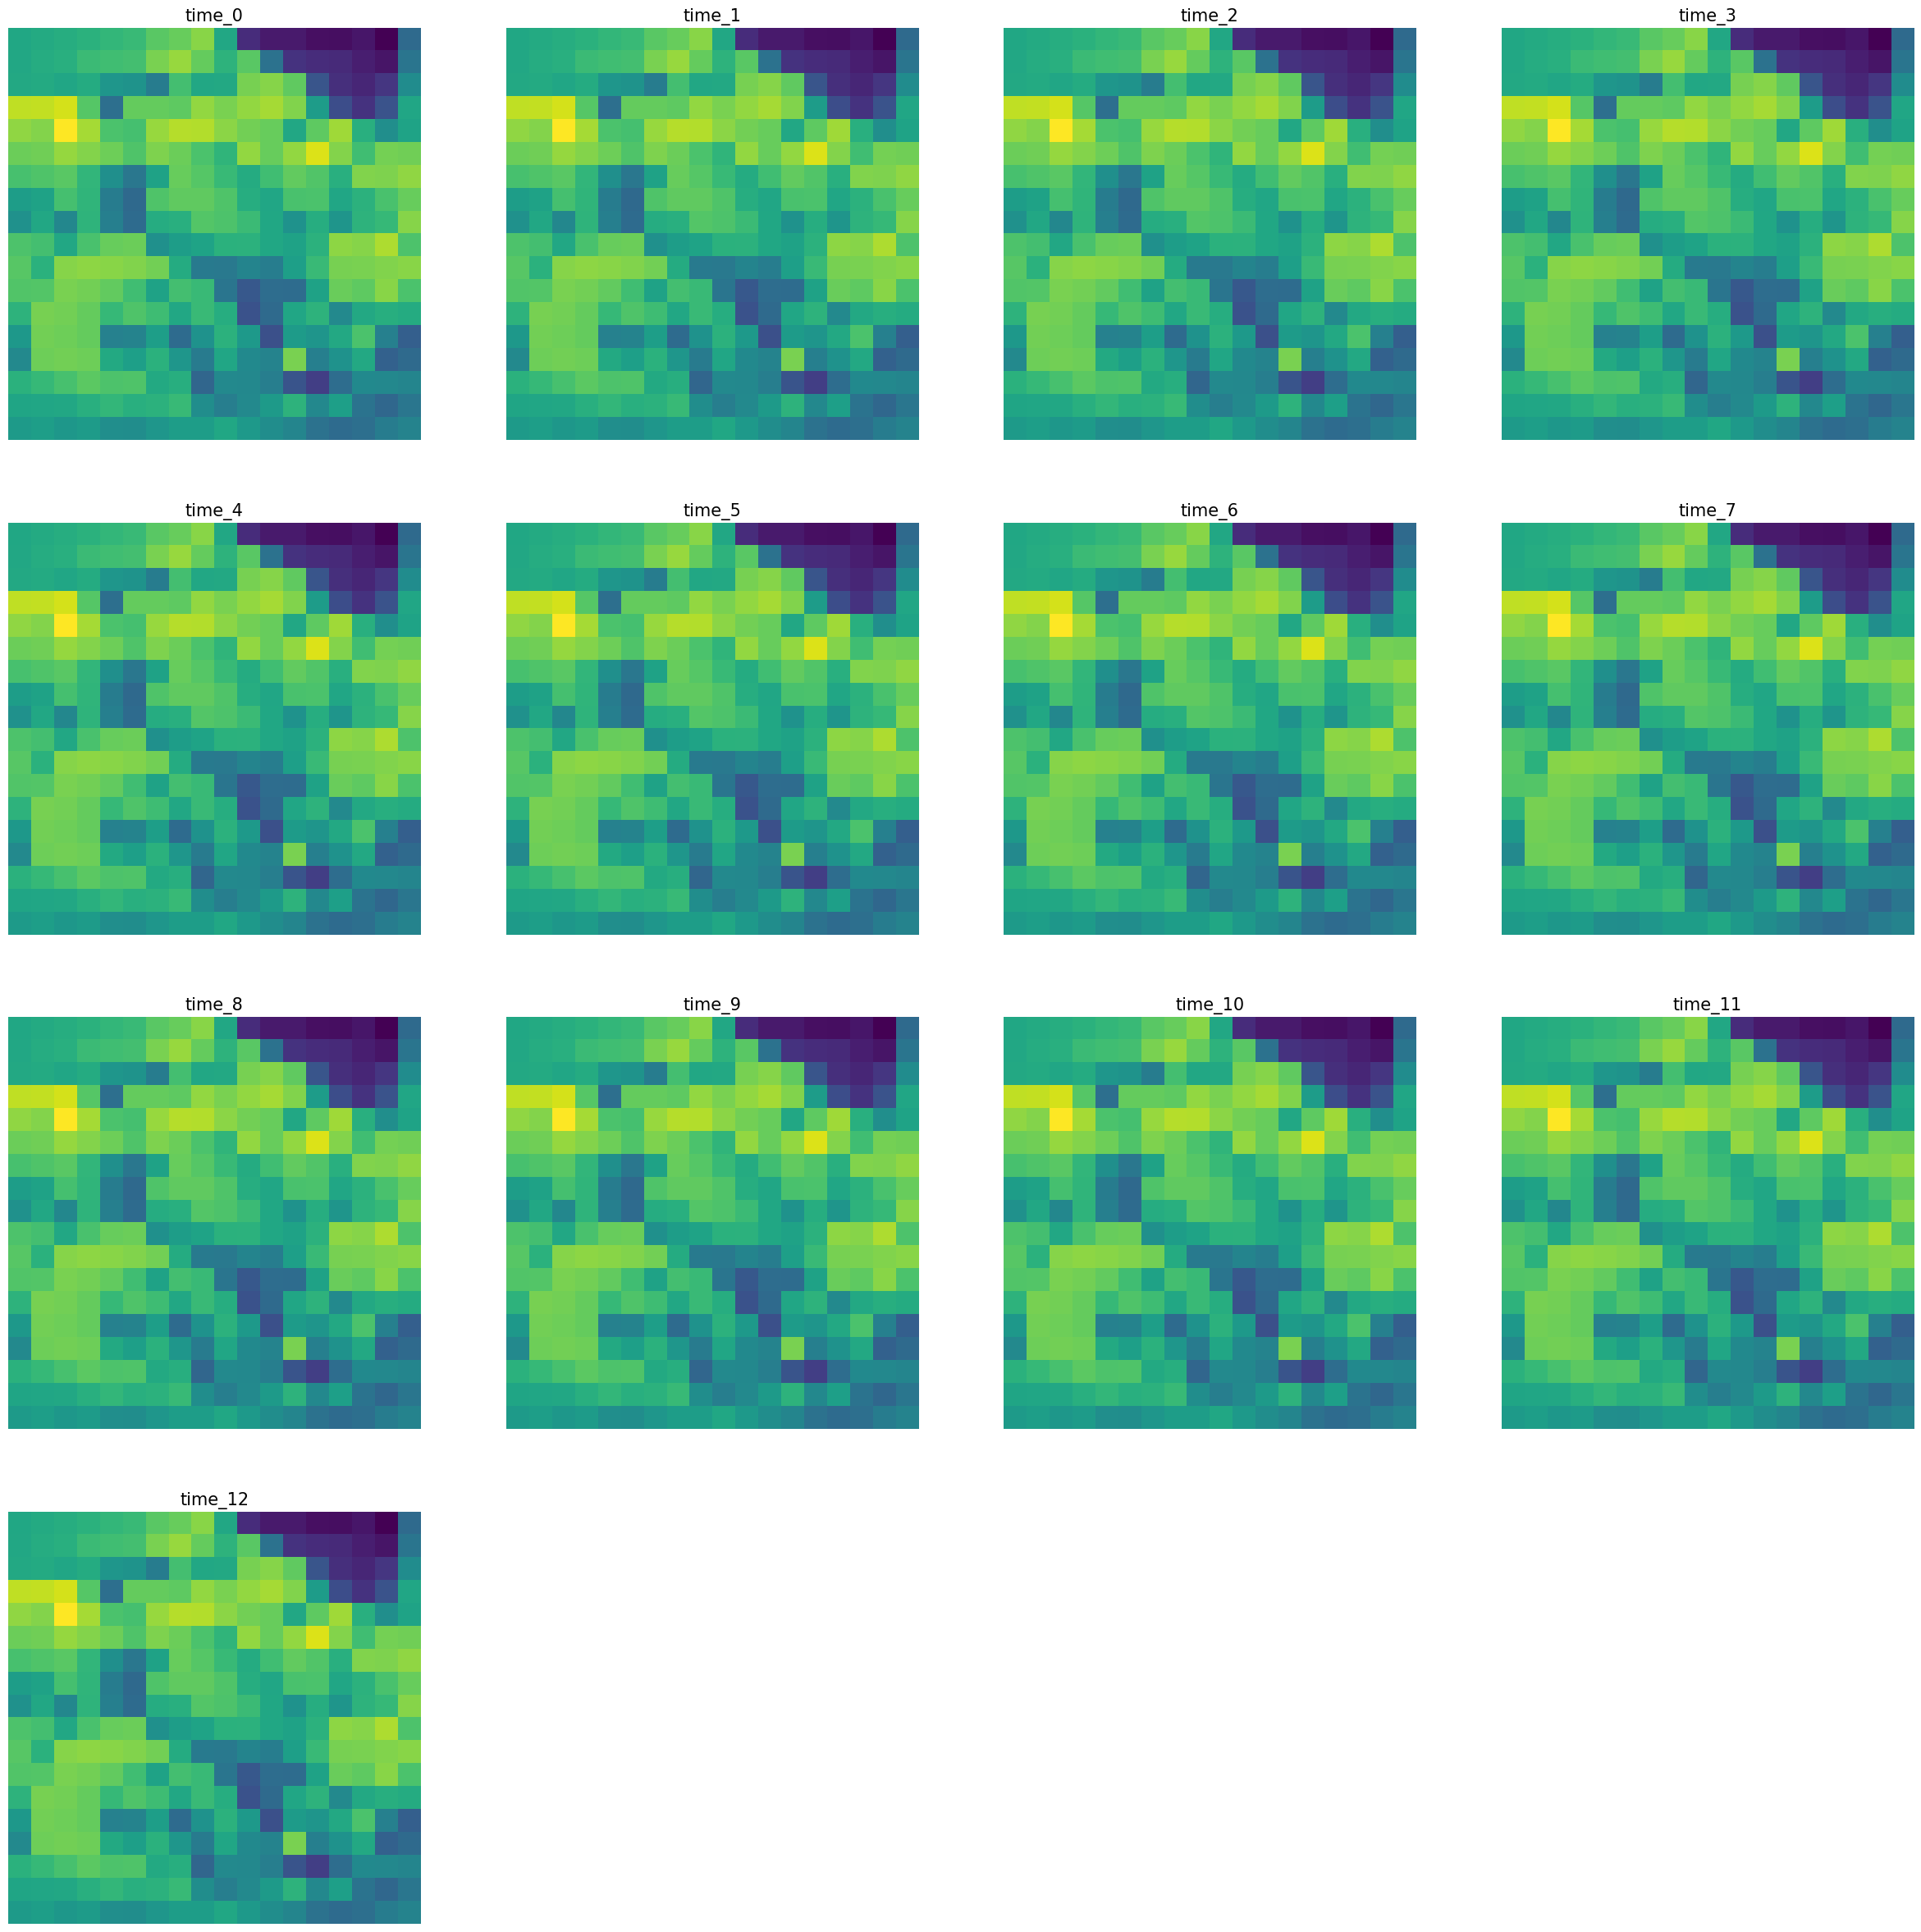

In [44]:
plot_maps(data, 'patchEmbed')

### 9 Test with single layer
We will use layer 8 since it was found to have the highest predictive performance across the cortex

In [45]:
# set-up
# model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BridgeTowerModel.from_pretrained("BridgeTower/bridgetower-base")
model = model.to(device)

# placeholder for batch features
features = {}
def get_features(name):
    def hook(model, input, output):
        # detached_outputs = [tensor.detach() for tensor in output]
        last_output = output[-1].detach()
        features[name] = last_output  # detached_outputs
    return hook

# register forward hooks with layers of choice
# First, convolutional layers
patch_embed = model.cross_modal_image_pooler.register_forward_hook(get_features('layer_8'))

In [46]:
snow_inputs, snow_num_inputs = inputs('video_data\snow_frames', 'snow.txt')

In [47]:
data = get_feature_vecs(snow_inputs, n=30)  # get average vector for each later every 30 frames

In [48]:
for i in range(len(data['layer_8'])):
    print(data['layer_8'][0][i])

tensor(0.0865)
tensor(-0.3689)
tensor(0.2189)
tensor(-0.4172)
tensor(0.0483)
tensor(0.2216)
tensor(0.1351)
tensor(-0.1915)
tensor(0.3595)
tensor(-0.0613)
tensor(-0.3213)
tensor(0.0907)
tensor(-0.0910)


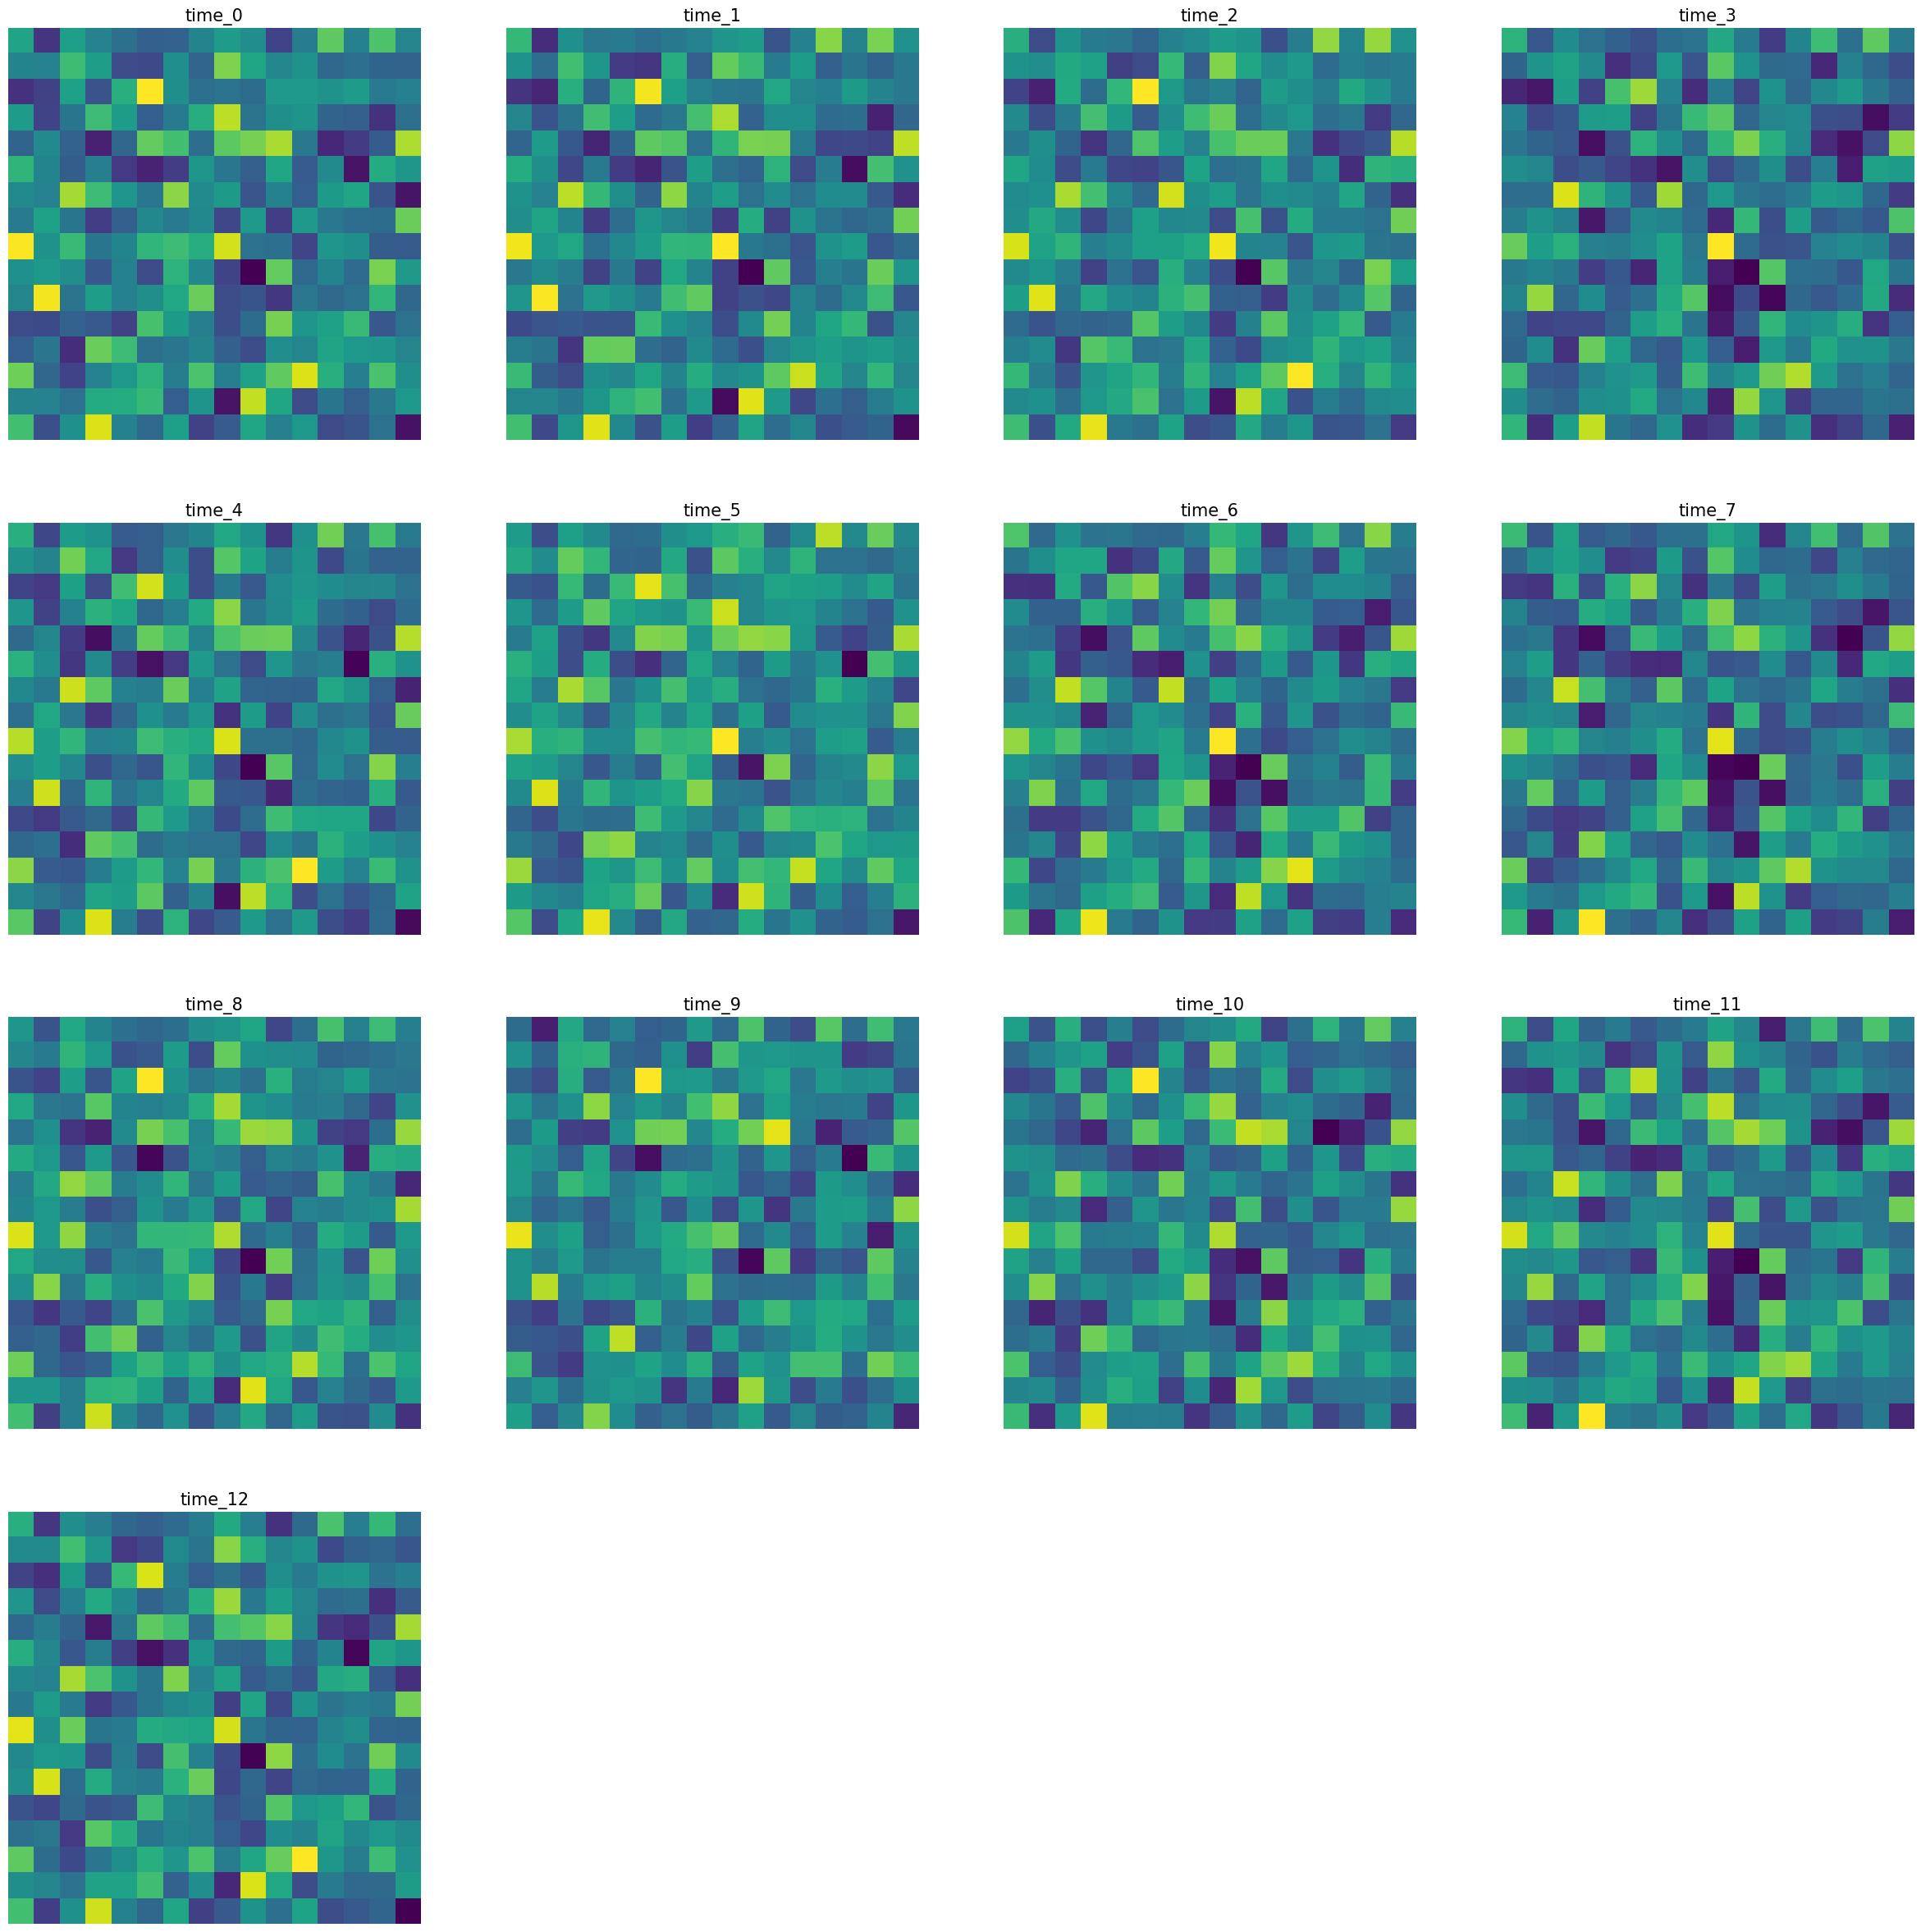

In [49]:
plot_maps(data, 'layer_8')

### 10 Ground truth with similar videos
Let's check what our model is encoding by feeding it three videos: two that are similar (dogs fishing) and one that is different (cars racing). The layer activations should be more similar at each time point (average of 30 frames) for the dog videos than the car video.

In [50]:
import json
from collections import defaultdict

In [51]:
# Let's find two similar videos and one that's different
# Assuming "MSRVTT/MSRVTT/annotation/MSR_VTT.json" is the path to your JSON file
file_path = r"MSRVTT\MSRVTT\annotation\MSR_VTT.json"

with open(file_path, "r") as file:
    video_annotations = json.load(file)

In [52]:
annotations = video_annotations['annotations']

In [53]:
# Word to search for
target_word = "dog"

# Count the occurrences of 'dog' in captions for each image_id
dog_count_per_video = defaultdict(int)

for entry in annotations:
    if target_word in entry['caption']:
        dog_count_per_video[entry['image_id']] += 1

# Filter videos with at least two different captions containing 'dog'
videos_with_dog_in_two_captions = [image_id for image_id, count in dog_count_per_video.items() if count >= 20]

print("Videos with the word '{}' in at least twenty captions: {}".format(target_word, set(videos_with_dog_in_two_captions)))

Videos with the word 'dog' in at least twenty captions: {'video5849', 'video7', 'video4469', 'video8866', 'video8760', 'video1873', 'video4123'}


In [54]:
# Word to search for
target_word = "car"

# Count the occurrences of 'car' in captions for each image_id
car_count_per_video = defaultdict(int)

for entry in annotations:
    if target_word in entry['caption']:
        car_count_per_video[entry['image_id']] += 1

# Filter videos with at least two different captions containing 'car'
videos_with_car_in_two_captions = [image_id for image_id, count in car_count_per_video.items() if count >= 20]

print("Videos with the word '{}' in at least twenty captions: {}".format(target_word, set(videos_with_car_in_two_captions)))

Videos with the word 'car' in at least twenty captions: {'video3332', 'video1356', 'video4602', 'video3375', 'video4868', 'video9328', 'video9358', 'video1801', 'video4378', 'video1870', 'video2827', 'video8871', 'video7354', 'video3253', 'video1718', 'video9949', 'video5968', 'video5305', 'video9668', 'video243', 'video3837', 'video7912', 'video1371', 'video939', 'video6624', 'video1638', 'video5113'}


In [55]:
import cv2 #importing openCV library
import imageio

def FrameCapture(path, folder_path): 
    # Open the video file using imageio
    video_reader = imageio.get_reader(path)
    
    # Initialize variables
    count = 0
    success = True

    # Process each frame
    while success:
        try:
            # Read the frame using imageio
            image = video_reader.get_data(count)

            # Saves the frames with frame-count 
            cv2.imwrite(folder_path + "frame%d.jpg" % count, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
            
            count += 1
        except IndexError:
            # No more frames to read
            success = False


In [56]:
dog1_video = r'MSRVTT\MSRVTT\videos\all\video4123.mp4'
dog2_video = r'MSRVTT\MSRVTT\videos\all\video1873.mp4'
car_video = r'MSRVTT\MSRVTT\videos\all\video1356.mp4'

dog1_captions = [entry['caption'] for entry in annotations if entry['image_id'] == 'video4123']
dog2_captions = [entry['caption'] for entry in annotations if entry['image_id'] == 'video1873']
car_captions = [entry['caption'] for entry in annotations if entry['image_id'] == 'video1356']

In [57]:
# Get frames for videos
FrameCapture(dog1_video, r'similarity_test\dog1\dog1_')
FrameCapture(dog2_video, r'similarity_test\dog2\dog2_')
FrameCapture(car_video, r'similarity_test\car\car_')

Let's redefine our inputs function so it works when we have less captions than frames for our video

In [58]:
def msr_inputs(folder_path, captions):
        processor = BridgeTowerProcessor.from_pretrained("BridgeTower/bridgetower-base")

        # Get images
        images = []
        if os.path.exists(folder_path):
                items = os.listdir(folder_path)

                for item in items:
                        item_path = os.path.join(folder_path, item)
                        images.append(Image.open(str(item_path)).convert('RGB'))

        num_images = len(images)
        reuse_caption = math.ceil(num_images/len(captions))

        full_captions = [item for item in captions for _ in range(reuse_caption)]
        # Make sure it's the same size as images
        texts = full_captions[:len(images)]

        inputs = [processor(image, text, return_tensors='pt') for image, text in zip(images, texts)]

        num_inputs = len(inputs)
        
        return inputs, num_inputs

In [59]:
# set-up
# model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BridgeTowerModel.from_pretrained("BridgeTower/bridgetower-base")
model = model.to(device)

# placeholder for batch features
features = {}
def get_features(name):
    def hook(model, input, output):
        # detached_outputs = [tensor.detach() for tensor in output]
        last_output = output[-1].detach()
        features[name] = last_output  # detached_outputs
    return hook

# register forward hooks with layers of choice
# First, convolutional layers
patch_embed = model.cross_modal_image_pooler.register_forward_hook(get_features('layer_8'))

In [60]:
dog1_inputs, dog1_num_inputs = msr_inputs('similarity_test\dog1', dog1_captions)
dog2_inputs, dog2_num_inputs = msr_inputs('similarity_test\dog2', dog2_captions)
car_inputs, car_num_inputs = msr_inputs('similarity_test\car', car_captions)

In [61]:
dog1_data = get_feature_vecs(dog1_inputs, n=30)

In [62]:
dog2_data = get_feature_vecs(dog2_inputs, n=30)
car_data = get_feature_vecs(car_inputs, n=30)

In [63]:
dog1 = dog1_data['layer_8'][:10]
dog2 = dog2_data['layer_8'][:10]
car = car_data['layer_8'][:10]
full_data = dog1 + dog2 + car

In [64]:
# Calculate correlation matrix
correlation_matrix = torch.zeros((len(dog1), len(full_data)))

In [65]:
for i, tensor in enumerate(full_data):
    for j, tensor1 in enumerate(dog1):
        similarity = torch.nn.functional.cosine_similarity(tensor.unsqueeze(0), tensor1.unsqueeze(0))
        correlation_matrix[j, i] = similarity

In [66]:
correlation_matrix_numpy = correlation_matrix.numpy()

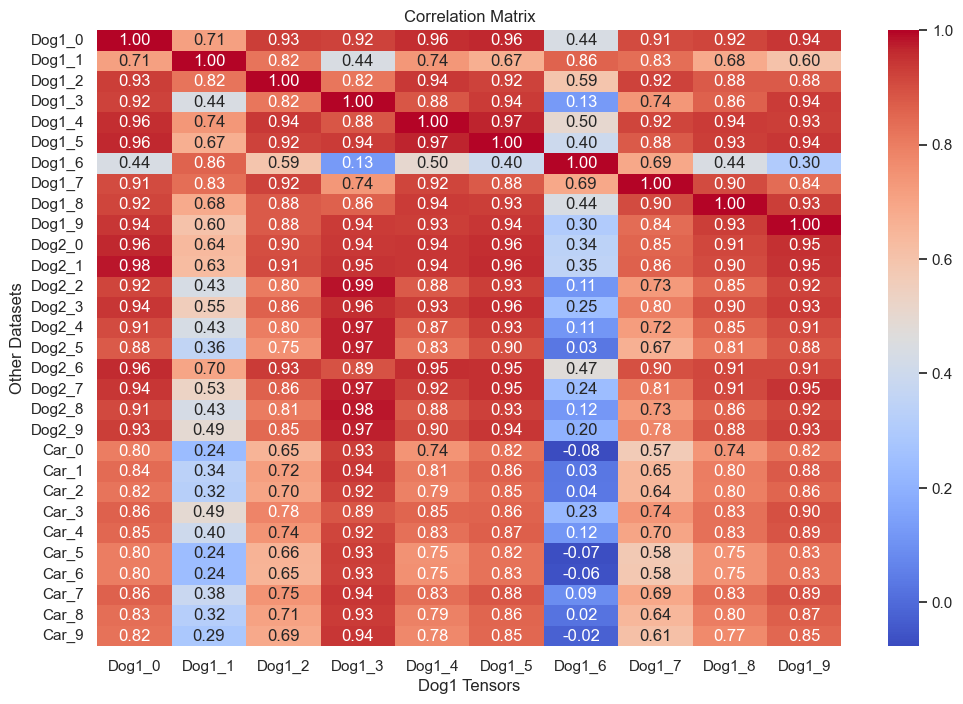

In [67]:
import seaborn as sns
# Create a heatmap using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.heatmap(np.transpose(correlation_matrix_numpy), cmap="coolwarm", annot=True, fmt=".2f",
            yticklabels=[f"Dog1_{i}" for i in range(10)] + [f"Dog2_{i}" for i in range(10)] + [f"Car_{i}" for i in range(10)],
            xticklabels=[f"Dog1_{i}" for i in range(10)])
plt.title('Correlation Matrix')
plt.ylabel('Other Datasets')
plt.xlabel('Dog1 Tensors')
plt.show()